In [6]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

def load_images_and_masks(base_data_dir, sub_dirs, img_size=(128, 128)):
    images = []
    masks = []
    
    for sub_dir in sub_dirs:
        data_dir = os.path.join(base_data_dir, sub_dir)
        files = sorted(os.listdir(data_dir))
        
        for file in files:
            if '_mask' in file:
                continue
            img_path = os.path.join(data_dir, file)
            mask_path = img_path.replace('.png', '_mask.png')
            
            # Load image
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize to [0, 1]
            
            # Load mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, img_size)
            mask = mask / 255.0  # Normalize to [0, 1]
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
            
            images.append(img)
            masks.append(mask)
    
    return np.array(images), np.array(masks)

# Load the images and masks from all subdirectories
base_data_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'
sub_dirs = ['benign', 'malignant', 'normal']
images, masks = load_images_and_masks(base_data_dir, sub_dirs)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

print(f'Training samples: {X_train.shape[0]}')
print(f'Validation samples: {X_val.shape[0]}')


Training samples: 624
Validation samples: 156


In [7]:
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + tf.keras.backend.epsilon()) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + tf.keras.backend.epsilon())

def iou(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())

def precision(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    true_positives = tf.reduce_sum(y_true_f * y_pred_f)
    predicted_positives = tf.reduce_sum(y_pred_f)
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def recall(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    true_positives = tf.reduce_sum(y_true_f * y_pred_f)
    possible_positives = tf.reduce_sum(y_true_f)
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * ((prec * rec) / (prec + rec + tf.keras.backend.epsilon()))

def specificity(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    true_negatives = tf.reduce_sum((1 - y_true_f) * (1 - y_pred_f))
    possible_negatives = tf.reduce_sum(1 - y_true_f)
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

def sensitivity(y_true, y_pred):
    return recall(y_true, y_pred)


In [8]:
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D(size=(2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = UpSampling2D(size=(2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = UpSampling2D(size=(2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = UpSampling2D(size=(2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = Conv2D(1, 1, activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[
        'accuracy', dice_coefficient, iou, precision, recall, f1_score, specificity, sensitivity])

    return model

# Build the model
model = unet_model()

# Display the model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ up_sampling2d[0]

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1720446065.107661     137 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8427 - dice_coefficient: 0.0973 - f1_score: 0.0973 - iou: 0.0519 - loss: 0.4432 - precision: 0.0747 - recall: 0.2316 - sensitivity: 0.2316 - specificity: 0.7563
Epoch 1: val_loss improved from inf to 0.22357, saving model to model-unet-enhanced.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.8435 - dice_coefficient: 0.0974 - f1_score: 0.0974 - iou: 0.0520 - loss: 0.4419 - precision: 0.0751 - recall: 0.2308 - sensitivity: 0.2308 - specificity: 0.7576 - val_accuracy: 0.9225 - val_dice_coefficient: 0.1680 - val_f1_score: 0.1680 - val_iou: 0.0917 - val_loss: 0.2236 - val_precision: 0.1505 - val_recall: 0.1915 - val_sensitivity: 0.1915 - val_specificity: 0.9104 - learning_rate: 1.0000e-04
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9164 - dice_coefficient: 0.1717 - f1_score: 0.1717 - iou: 0.0947 - loss: 0.2234 - precision: 0.1780 - recall: 0.1815 - sensitivity: 0.1815 - specificity: 0.9270
Epoch 2: val_

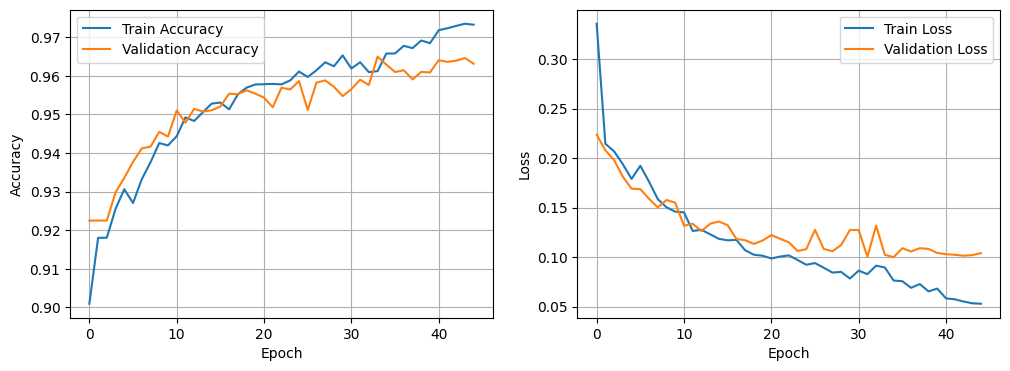

In [9]:
# Data augmentation
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Fit the data generators to the training data
seed = 42
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

# Create data generators
image_generator = image_datagen.flow(X_train, batch_size=8, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=8, seed=seed)

# Create custom data generator
def custom_data_generator(image_generator, mask_generator):
    while True:
        image_batch = next(image_generator)
        mask_batch = next(mask_generator)
        yield image_batch, mask_batch

train_generator = custom_data_generator(image_generator, mask_generator)

# Define callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ModelCheckpoint('model-unet-enhanced.keras', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
]

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // 8,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

# Save the final model
model.save('unet_final_model_lr.keras')

# Plot the training and validation accuracy and loss at each epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


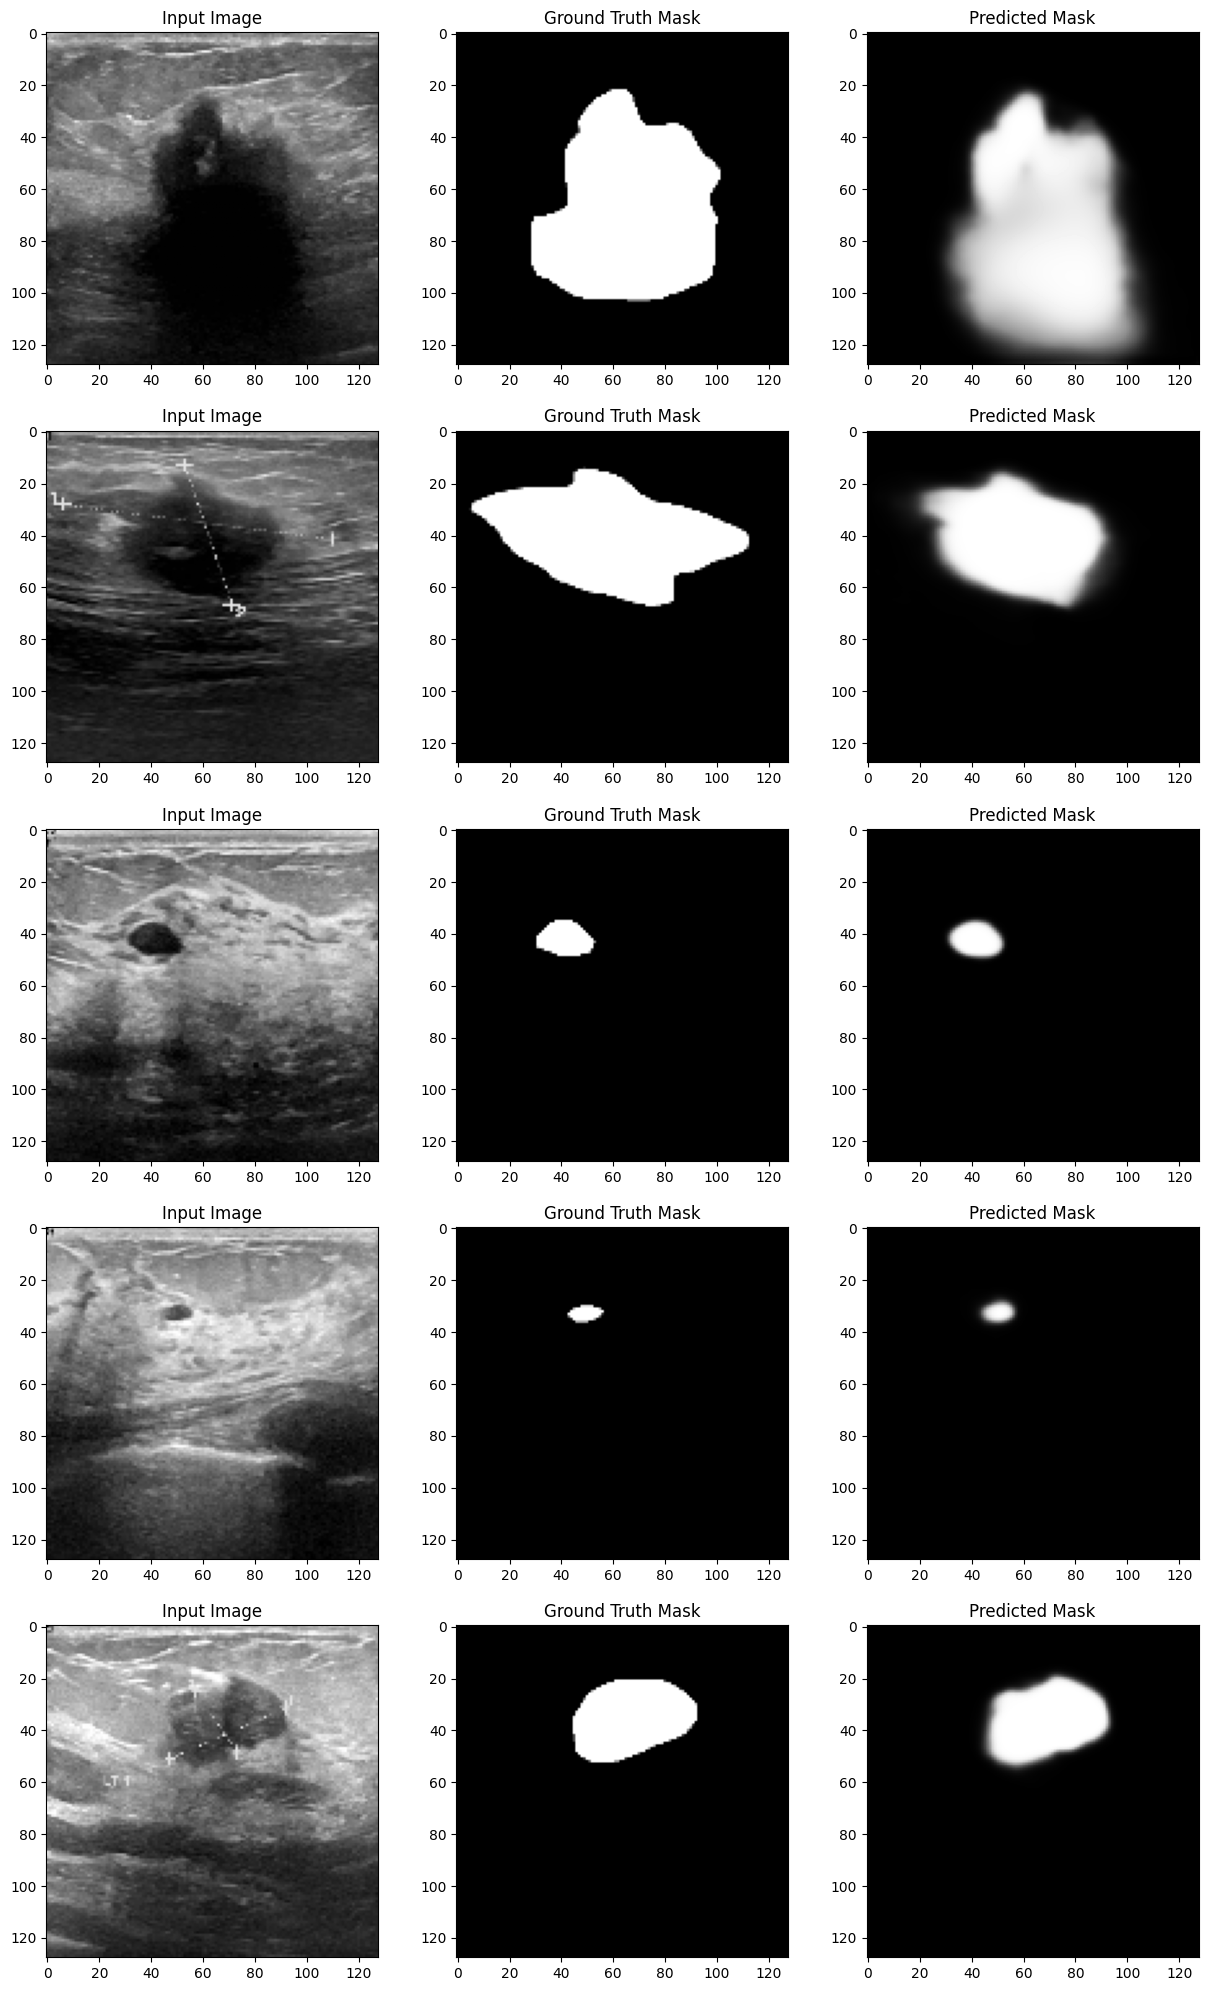

In [18]:
import random

def plot_predictions(model, X_val, y_val, num_samples=5):
    plt.figure(figsize=(15, num_samples * 5))
    for i in range(num_samples):
        idx = random.randint(0, len(X_val) - 1)
        img = X_val[idx]
        true_mask = y_val[idx]
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
        
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img)
        plt.title('Input Image')
        
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
    
    plt.show()

# Plot predictions
plot_predictions(model, X_val, y_val)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


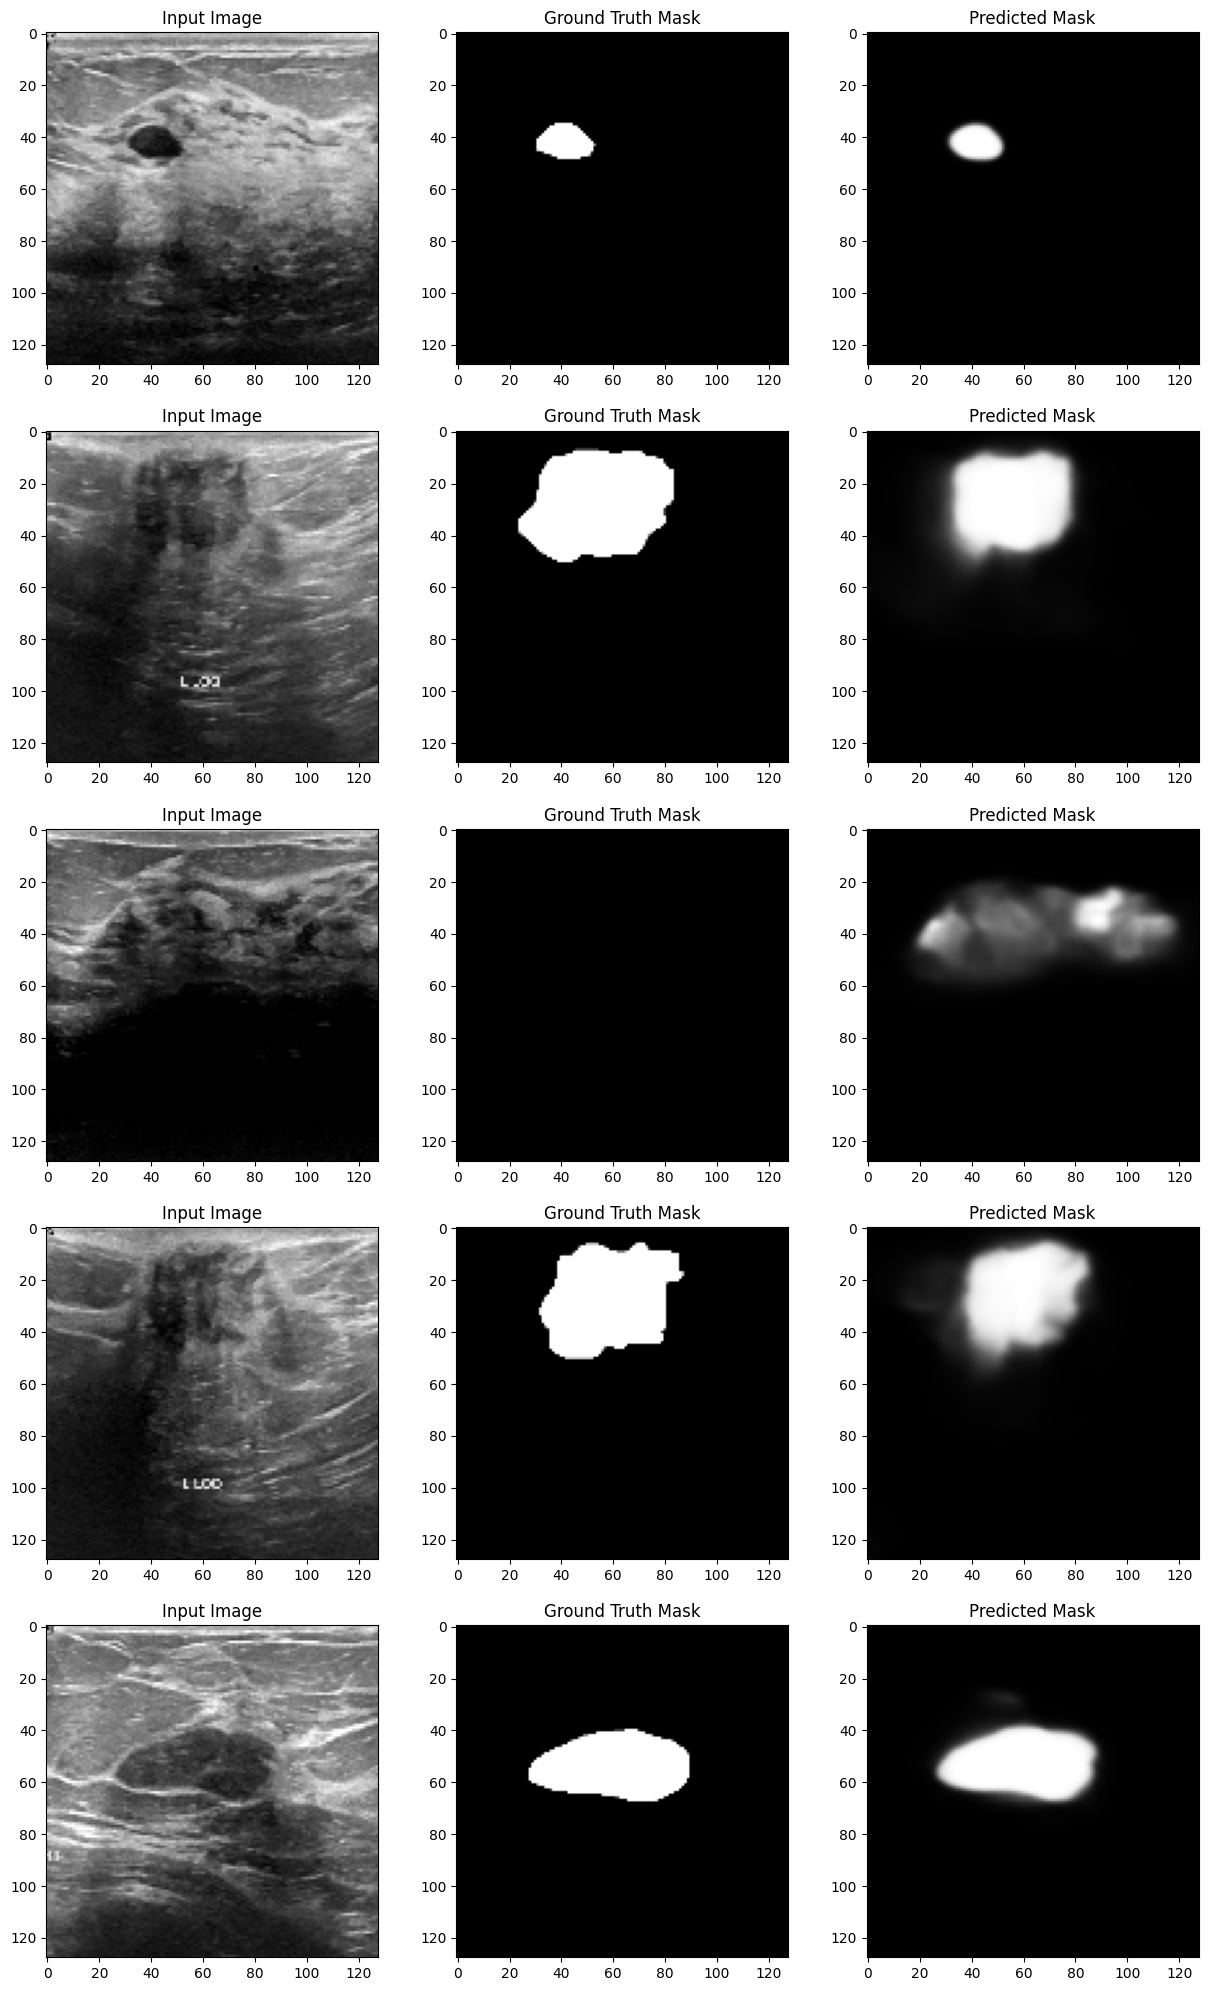

In [22]:
import matplotlib.pyplot as plt
import random

def plot_predictions(model, X_val, y_val, num_samples=5):
    plt.figure(figsize=(15, num_samples * 5))
    for i in range(num_samples):
        idx = random.randint(0, len(X_val) - 1)
        img = X_val[idx]
        true_mask = y_val[idx]
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
        
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img)
        plt.title('Input Image')
        
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
    
    plt.show()

# Assuming the model and validation data (X_val, y_val) are already loaded
plot_predictions(model, X_val, y_val)


In [21]:
import random
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model

# Define the dice coefficient
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

# Load the models
model = load_model('/kaggle/working/unet_final_model_lr.keras', custom_objects={'dice_coefficient': dice_coefficient})

def plot_predictions(model, X_val, y_val, num_samples=5):
    plt.figure(figsize=(15, num_samples * 5))
    for i in range(num_samples):
        idx = random.randint(0, len(X_val) - 1)
        img = X_val[idx]
        true_mask = y_val[idx]
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
        
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img)
        plt.title('Input Image')
        
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
    
    plt.show()

# Assuming you have loaded your X_val and y_val
# X_val, y_val = load_your_validation_data()

# Plot predictions
# plot_predictions(model, X_val, y_val)


In [16]:
import os
from keras.models import load_model
import tensorflow as tf

# Define and register custom functions
@tf.keras.utils.register_keras_serializable()
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

@tf.keras.utils.register_keras_serializable()
def iou(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())

@tf.keras.utils.register_keras_serializable()
def precision(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    true_positives = tf.keras.backend.sum(y_true_f * y_pred_f)
    predicted_positives = tf.keras.backend.sum(y_pred_f)
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

@tf.keras.utils.register_keras_serializable()
def recall(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    true_positives = tf.keras.backend.sum(y_true_f * y_pred_f)
    possible_positives = tf.keras.backend.sum(y_true_f)
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

@tf.keras.utils.register_keras_serializable()
def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * ((prec * rec) / (prec + rec + tf.keras.backend.epsilon()))

@tf.keras.utils.register_keras_serializable()
def specificity(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    true_negatives = tf.keras.backend.sum((1 - y_true_f) * (1 - y_pred_f))
    possible_negatives = tf.keras.backend.sum(1 - y_true_f)
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

@tf.keras.utils.register_keras_serializable()
def sensitivity(y_true, y_pred):
    return recall(y_true, y_pred)

# Path to the model file
model_path = '/kaggle/working/unet_final_enhanced_lr.keras'

# Debugging: Print current working directory and list files
print(f"Current working directory: {os.getcwd()}")
print(f"Files in the directory: {os.listdir(os.getcwd())}")

# Check if the file exists
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found: {model_path}")

# Load the segmentation model with all custom objects
custom_objects = {
    'dice_coefficient': dice_coefficient,
    'iou': iou,
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score,
    'specificity': specificity,
    'sensitivity': sensitivity
}

segmentation_model = load_model(model_path, custom_objects=custom_objects)

# Print the model summary to ensure the output shape
segmentation_model.summary()


Current working directory: /kaggle/working
Files in the directory: ['unet_final_model_lr.keras', 'model-unet-enhanced.keras', '.virtual_documents']


FileNotFoundError: Model file not found: /kaggle/working/unet_final_enhanced_lr.keras

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score, confusion_matrix
import numpy as np
import tensorflow as tf

def calculate_metrics(y_true, y_pred, threshold=0.5):
    y_true_flat = (y_true.flatten() > threshold).astype(int)
    y_pred_flat = (y_pred.flatten() > threshold).astype(int)

    precision = precision_score(y_true_flat, y_pred_flat, zero_division=1)
    recall = recall_score(y_true_flat, y_pred_flat, zero_division=1)
    f1 = f1_score(y_true_flat, y_pred_flat, zero_division=1)
    iou = jaccard_score(y_true_flat, y_pred_flat, zero_division=1)
    
    # Handle cases where confusion_matrix might not have all values
    cm = confusion_matrix(y_true_flat, y_pred_flat)
    if cm.size == 1:  # Only one class present
        tn, fp, fn, tp = (cm[0, 0], 0, 0, 0) if y_true_flat[0] == 0 else (0, cm[0, 0], 0, 0)
    elif cm.shape == (1, 2):  # No true positives or false negatives
        tn, fp, fn, tp = cm[0, 0], cm[0, 1], 0, 0
    elif cm.shape == (2, 1):  # No false positives or true negatives
        tn, fp, fn, tp = 0, 0, cm[0, 0], cm[1, 0]
    else:
        tn, fp, fn, tp = cm.ravel()
    
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 1.0
    
    return precision, recall, f1, iou, specificity

# Assuming 'predicted_masks' contains the predicted masks from the model
predicted_masks = model.predict(X_val)

# Compute the metrics for each validation sample and average them
precision_list = []
recall_list = []
f1_list = []
iou_list = []
specificity_list = []

for i in range(len(y_val)):
    precision, recall, f1, iou, specificity = calculate_metrics(y_val[i], predicted_masks[i])
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    iou_list.append(iou)
    specificity_list.append(specificity)

average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_f1 = np.mean(f1_list)
average_iou = np.mean(iou_list)
average_specificity = np.mean(specificity_list)

print(f'Average Precision: {average_precision:.4f}')
print(f'Average Recall: {average_recall:.4f}')
print(f'Average F1 Score: {average_f1:.4f}')
print(f'Average IoU: {average_iou:.4f}')
print(f'Average Specificity: {average_specificity:.4f}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step
Average Precision: 0.8172
Average Recall: 0.7890
Average F1 Score: 0.7246
Average IoU: 0.6592
Average Specificity: 0.9861


In [104]:
import os
import shutil

# Base directories
base_data_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'
target_dir = '/kaggle/working/classification_dataset/'

# Subdirectories in the base data directory
sub_dirs = ['benign', 'malignant', 'normal']

# Create target directory structure
os.makedirs(os.path.join(target_dir, 'train', 'normal'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'train', 'benign'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'train', 'malignant'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'val', 'normal'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'val', 'benign'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'val', 'malignant'), exist_ok=True)

# Function to move files to respective directories
def move_files(sub_dir, label):
    files = sorted(os.listdir(os.path.join(base_data_dir, sub_dir)))
    train_split = int(0.8 * len(files))
    for i, file in enumerate(files):
        if '_mask' in file:
            continue
        if i < train_split:
            target = 'train'
        else:
            target = 'val'
        shutil.copy(os.path.join(base_data_dir, sub_dir, file),
                    os.path.join(target_dir, target, label, file))

# Move files
for sub_dir in sub_dirs:
    move_files(sub_dir, sub_dir)

print('Data reorganized successfully.')


Data reorganized successfully.


In [107]:
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Data directories
train_dir = '/kaggle/working/classification_dataset/train'
val_dir = '/kaggle/working/classification_dataset/val'

# Image Data Generator
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(128, 128), batch_size=32, class_mode='categorical')

# Load pre-trained VGG16 model + higher level layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)  # 3 classes: normal, benign, malignant

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ModelCheckpoint('classification_model.keras', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
]

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=callbacks)

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {accuracy:.4f}')


Found 625 images belonging to 3 classes.
Found 155 images belonging to 3 classes.
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/20 ━━━━━━━━━━━━━━━━━━━━ 2:13 7s/step - accuracy: 0.6250 - loss: 1.0764

W0000 00:00:1720185310.644319     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.5039 - loss: 1.1299

W0000 00:00:1720185325.702278     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720185327.615640     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.85591, saving model to classification_model.keras


W0000 00:00:1720185341.155877     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5046 - loss: 1.1255 - val_accuracy: 0.6710 - val_loss: 0.8559 - learning_rate: 1.0000e-04
Epoch 2/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.5811 - loss: 0.8896
Epoch 2: val_loss improved from 0.85591 to 0.83515, saving model to classification_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 361ms/step - accuracy: 0.5832 - loss: 0.8911 - val_accuracy: 0.6387 - val_loss: 0.8351 - learning_rate: 1.0000e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.6066 - loss: 0.8800
Epoch 3: val_loss improved from 0.83515 to 0.74130, saving model to classification_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 361ms/step - accuracy: 0.6077 - loss: 0.8784 - val_accuracy: 0.6839 - val_loss: 0.7413 - learning_rate: 1.0000e-04
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.6478 - loss: 0.8048
Epoch 4: val_loss improved from 0.74130 to 0.73072, saving model to classification_model.keras
20/20 ━━━━━━━━━━━━━━━━

In [111]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Base directory containing the original dataset
base_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

# New directories for training and validation
new_base_dir = '/kaggle/working/breast_ultrasound_split'
train_dir = os.path.join(new_base_dir, 'train')
val_dir = os.path.join(new_base_dir, 'val')

# Create train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Class subdirectories
classes = ['benign', 'malignant', 'normal']
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

# Function to split and move the dataset
def split_and_move_dataset(base_dir, new_base_dir, split_ratio=0.2):
    for cls in classes:
        cls_dir = os.path.join(base_dir, cls)
        files = os.listdir(cls_dir)
        
        train_files, val_files = train_test_split(files, test_size=split_ratio, random_state=42)
        
        for file in train_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(new_base_dir, 'train', cls, file)
            shutil.copyfile(src, dst)
        
        for file in val_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(new_base_dir, 'val', cls, file)
            shutil.copyfile(src, dst)

# Split and move the dataset
split_and_move_dataset(base_dir, new_base_dir)


Found 1260 images belonging to 3 classes.
Found 318 images belonging to 3 classes.
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/40 ━━━━━━━━━━━━━━━━━━━━ 21:19 33s/step - accuracy: 0.2812 - loss: 1.4510

W0000 00:00:1720186184.301153     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.4764 - loss: 1.0156

W0000 00:00:1720186217.289002     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.59531, saving model to classification_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.4790 - loss: 1.0114 - val_accuracy: 0.7956 - val_loss: 0.5953 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.6387 - loss: 0.7850
Epoch 2: val_loss improved from 0.59531 to 0.58951, saving model to classification_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 311ms/step - accuracy: 0.6386 - loss: 0.7851 - val_accuracy: 0.7673 - val_loss: 0.5895 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.7395 - loss: 0.6437
Epoch 3: val_loss did not improve from 0.58951
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 294ms/step - accuracy: 0.7397 - loss: 0.6420 - val_accuracy: 0.8050 - val_loss: 0.6635 - learning_rate: 1.0000e-04
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.7558 - loss: 0.5659
Epoch 4: val_loss improved from 0.58951 to 0.35581, saving model to class

W0000 00:00:1720186690.073087     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step
Classification Report:

              precision    recall  f1-score   support

      benign       0.92      0.97      0.94       179
   malignant       0.93      0.87      0.90        85
      normal       1.00      0.93      0.96        54

    accuracy                           0.93       318
   macro avg       0.95      0.92      0.93       318
weighted avg       0.94      0.93      0.93       318



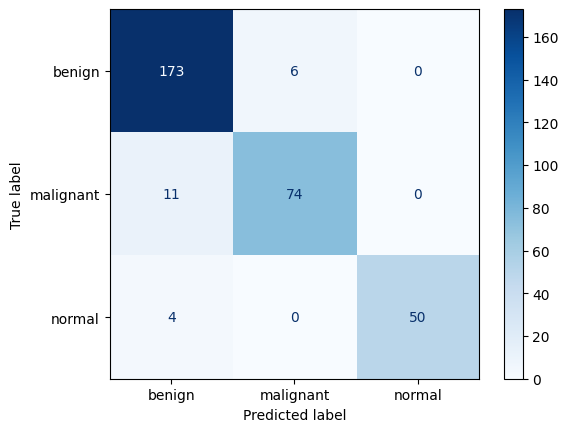

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


W0000 00:00:1720186693.084293     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


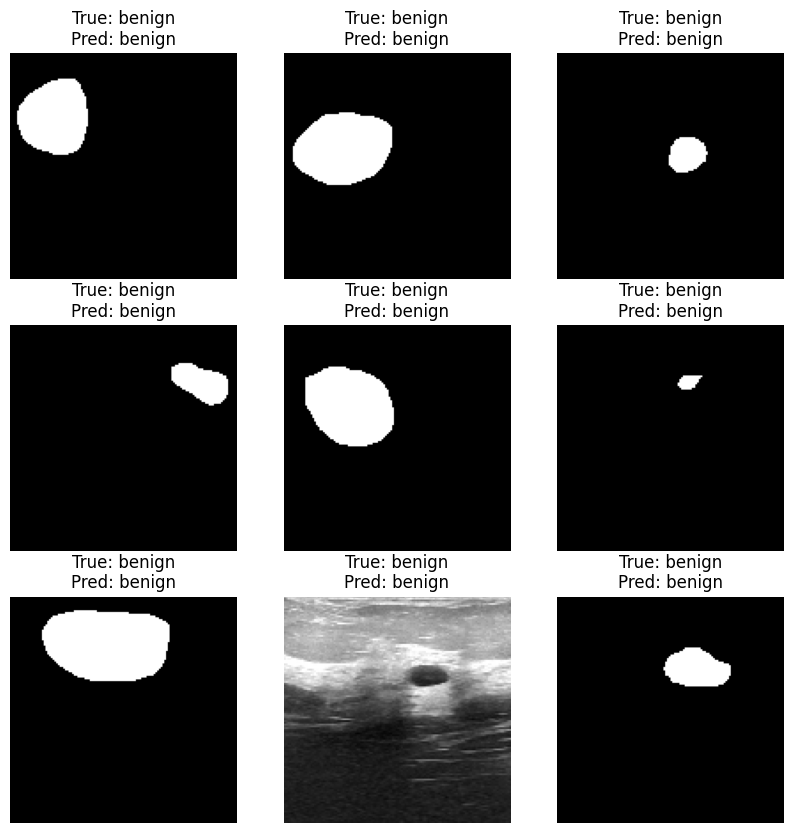

In [112]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Data directories
train_dir = '/kaggle/working/breast_ultrasound_split/train'
val_dir = '/kaggle/working/breast_ultrasound_split/val'

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False
)

# Load VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ModelCheckpoint('classification_model.keras', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

# Evaluate the model
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(val_generator.class_indices.keys())))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Visualize predictions
def plot_images(images, labels, preds, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')
    plt.show()

# Get a batch of validation images
val_images, val_labels = next(val_generator)
val_preds = np.argmax(model.predict(val_images), axis=1)

# Plot the images with true and predicted labels
plot_images(val_images, np.argmax(val_labels, axis=1), val_preds, list(val_generator.class_indices.keys()))


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


W0000 00:00:1720186860.000163     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


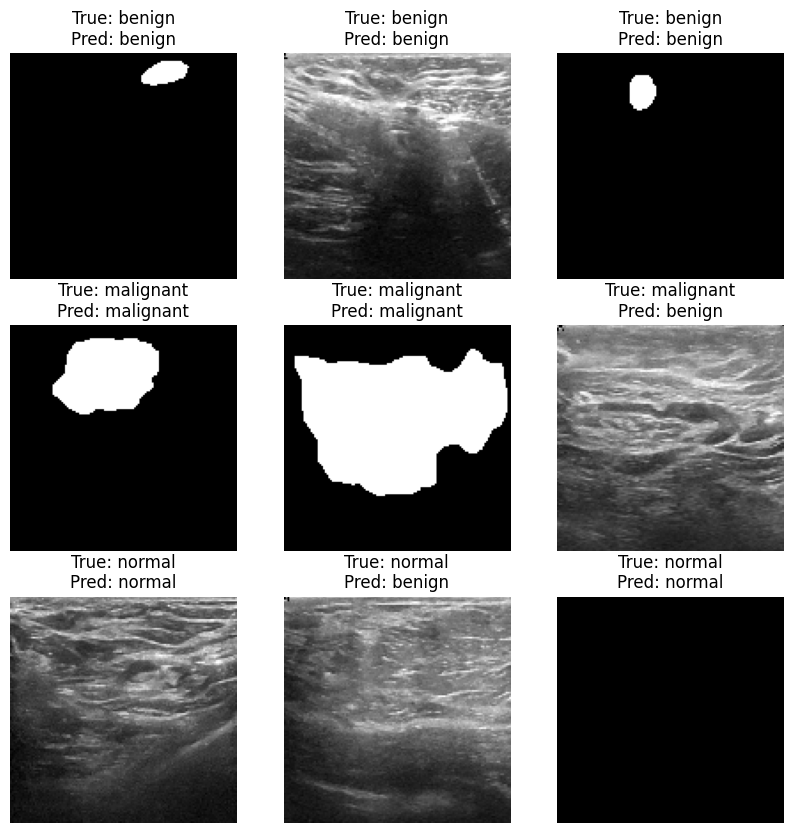

In [114]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

# Define the directories
base_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
categories = ['benign', 'malignant', 'normal']

# Function to load a random set of images
def load_random_images(base_dir, categories, num_images=9):
    images = []
    labels = []

    for category in categories:
        category_dir = os.path.join(base_dir, category)
        category_images = os.listdir(category_dir)
        random_images = random.sample(category_images, num_images // len(categories))

        for img_name in random_images:
            img_path = os.path.join(category_dir, img_name)
            img = image.load_img(img_path, target_size=(128, 128))
            img = image.img_to_array(img)
            img = img / 255.0
            images.append(img)
            labels.append(category)

    return np.array(images), labels

# Load random images
num_images = 9
images, labels = load_random_images(base_dir, categories, num_images=num_images)

# Predict the classes
predictions = model.predict(images)
predicted_labels = [categories[np.argmax(pred)] for pred in predictions]

# Visualize the results
plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"True: {labels[i]}\nPred: {predicted_labels[i]}")
    plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


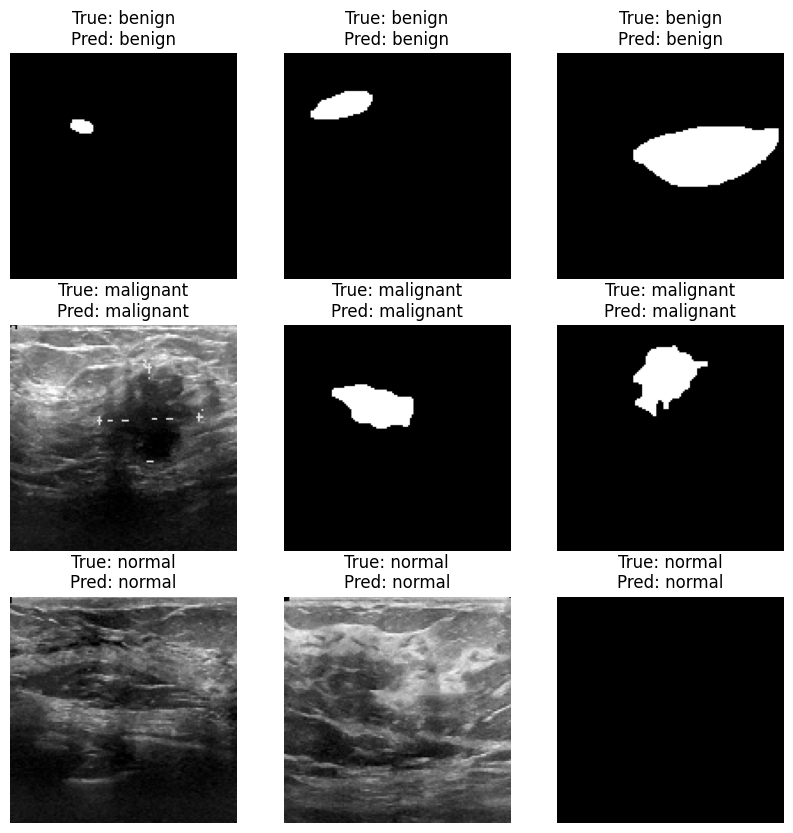

In [115]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

# Define the directories
base_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
categories = ['benign', 'malignant', 'normal']

# Function to load a random set of images
def load_random_images(base_dir, categories, num_images=9):
    images = []
    labels = []

    for category in categories:
        category_dir = os.path.join(base_dir, category)
        category_images = os.listdir(category_dir)
        random_images = random.sample(category_images, num_images // len(categories))

        for img_name in random_images:
            img_path = os.path.join(category_dir, img_name)
            img = image.load_img(img_path, target_size=(128, 128))
            img = image.img_to_array(img)
            img = img / 255.0
            images.append(img)
            labels.append(category)

    return np.array(images), labels

# Load random images
num_images = 9
images, labels = load_random_images(base_dir, categories, num_images=num_images)

# Predict the classes
predictions = model.predict(images)
predicted_labels = [categories[np.argmax(pred)] for pred in predictions]

# Visualize the results
plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"True: {labels[i]}\nPred: {predicted_labels[i]}")
    plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


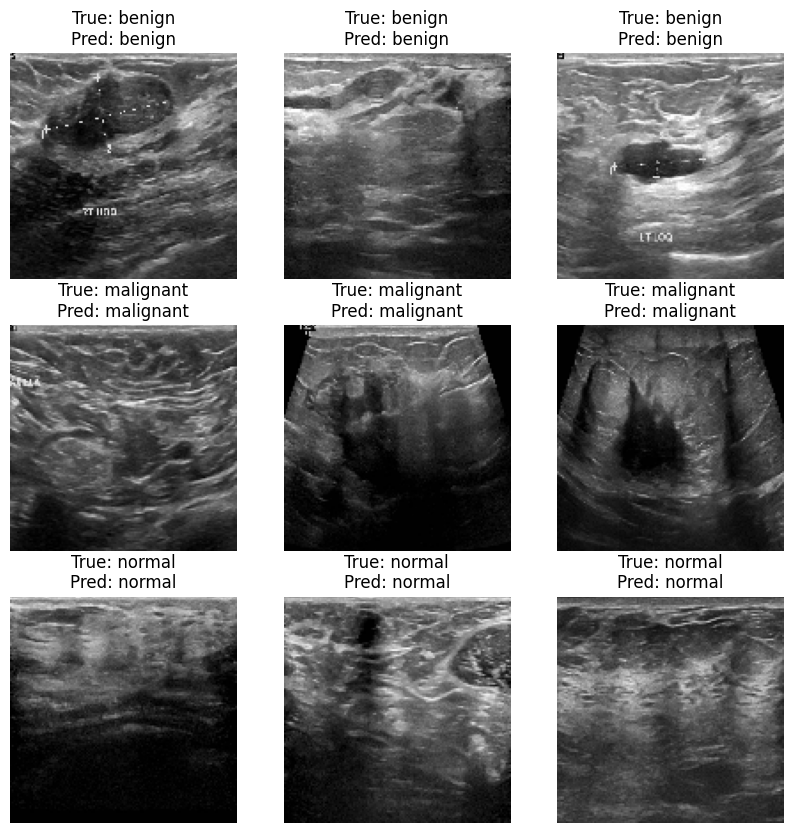

In [131]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

# Define the directories
base_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
categories = ['benign', 'malignant', 'normal']

# Function to load a random set of images
def load_random_images(base_dir, categories, num_images=9):
    images = []
    labels = []

    for category in categories:
        category_dir = os.path.join(base_dir, category)
        category_images = [img for img in os.listdir(category_dir) if not img.endswith('_mask.png')]
        random_images = random.sample(category_images, num_images // len(categories))

        for img_name in random_images:
            img_path = os.path.join(category_dir, img_name)
            img = image.load_img(img_path, target_size=(128, 128))
            img = image.img_to_array(img)
            img = img / 255.0
            images.append(img)
            labels.append(category)

    return np.array(images), labels

# Load random images
num_images = 9
images, labels = load_random_images(base_dir, categories, num_images=num_images)

# Predict the classes
predictions = model.predict(images)
predicted_labels = [categories[np.argmax(pred)] for pred in predictions]

# Visualize the results
plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"True: {labels[i]}\nPred: {predicted_labels[i]}")
    plt.axis("off")
plt.show()


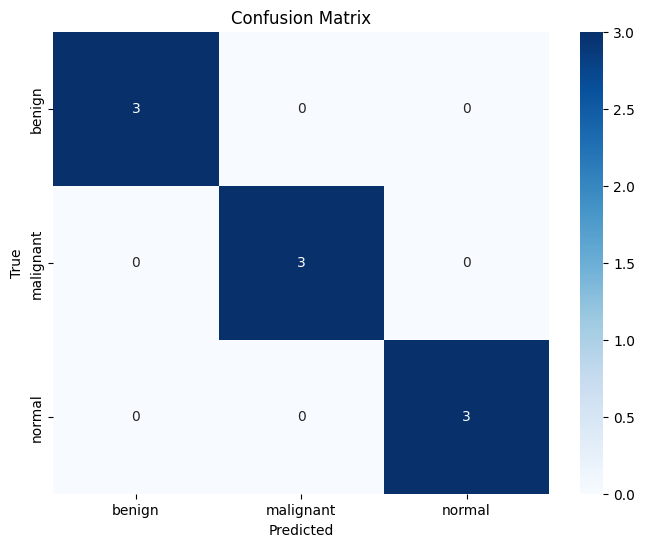

Classification Report:
               precision    recall  f1-score   support

      benign       1.00      1.00      1.00         3
   malignant       1.00      1.00      1.00         3
      normal       1.00      1.00      1.00         3

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



In [125]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Assuming you have true labels and predicted labels
true_labels = labels
predicted_labels = [categories[np.argmax(pred)] for pred in predictions]

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=categories)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(true_labels, predicted_labels, target_names=categories)
print("Classification Report:\n", class_report)


In [121]:
import tensorflow as tf
from keras.models import load_model
from keras import backend as K

# Define the dice coefficient
def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

# Ensure dice coefficient is registered
tf.keras.utils.get_custom_objects().update({'dice_coefficient': dice_coefficient})

# Assuming `model` is your segmentation model
# model = ... (your segmentation model definition here)
model.save('unet_final_enhanced_lr.keras')
print("Segmentation model saved to 'unet_final_enhanced_lr.keras'")


Segmentation model saved to 'unet_final_enhanced_lr.keras'


Classification model loaded from 'classification_model.keras'
 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step 

W0000 00:00:1720188076.694157     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step
Classification Report:

              precision    recall  f1-score   support

      benign       0.92      0.96      0.94       179
   malignant       0.93      0.87      0.90        85
      normal       0.98      0.94      0.96        54

    accuracy                           0.93       318
   macro avg       0.94      0.93      0.93       318
weighted avg       0.93      0.93      0.93       318



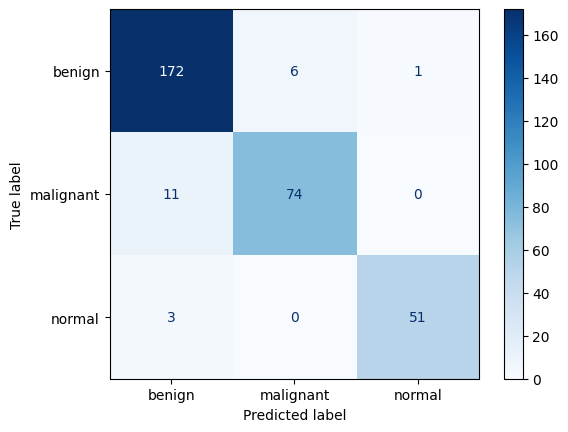

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


W0000 00:00:1720188079.715832     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


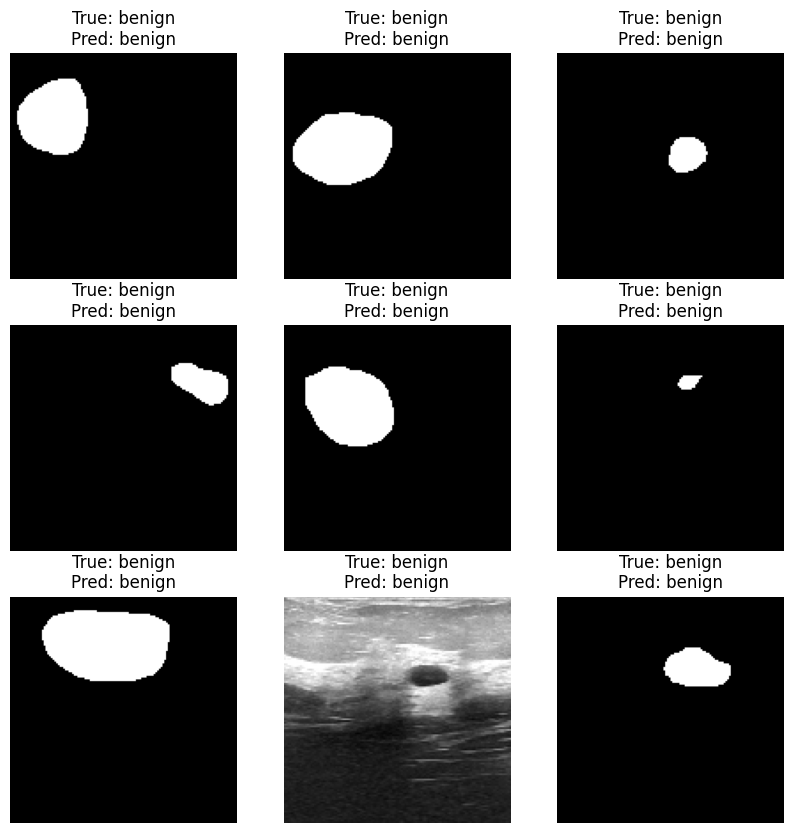

In [124]:
from keras.models import load_model

# Load the saved classification model
classification_model = load_model('classification_model.keras')
print("Classification model loaded from 'classification_model.keras'")

# Evaluate the model
val_generator.reset()
y_pred = classification_model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(val_generator.class_indices.keys())))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Visualize predictions
def plot_images(images, labels, preds, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')
    plt.show()

# Get a batch of validation images
val_images, val_labels = next(val_generator)
val_preds = np.argmax(classification_model.predict(val_images), axis=1)

# Plot the images with true and predicted labels
plot_images(val_images, np.argmax(val_labels, axis=1), val_preds, list(val_generator.class_indices.keys()))


In [126]:
classification_model.save('classification_model_saved.keras')
print("Classification model saved to 'classification_model_saved.keras'")


Classification model saved to 'classification_model_saved.keras'


In [4]:
from keras.models import load_model

# Load the saved models
segmentation_model = load_model('unet_final_enhanced_lr.keras')
classification_model = load_model('classification_model_saved.keras')

print("Models loaded successfully.")


2024-07-08 13:36:57.618231: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 13:36:57.618334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 13:36:57.909797: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


ValueError: File not found: filepath=unet_final_enhanced_lr.keras. Please ensure the file is an accessible `.keras` zip file.

In [128]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory containing the new dataset
new_data_dir = '/kaggle/input/ultrasound-breast-images-for-breast-cancer'

# Data generator for the new dataset
new_data_datagen = ImageDataGenerator(rescale=1./255)

# Create a data generator for the new dataset
new_data_generator = new_data_datagen.flow_from_directory(
    new_data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False
)


Found 9016 images belonging to 1 classes.


Found 318 images belonging to 3 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step 

W0000 00:00:1720188365.787664     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step
Classification Report:

              precision    recall  f1-score   support

      benign       0.92      0.96      0.94       179
   malignant       0.93      0.87      0.90        85
      normal       0.98      0.94      0.96        54

    accuracy                           0.93       318
   macro avg       0.94      0.93      0.93       318
weighted avg       0.93      0.93      0.93       318



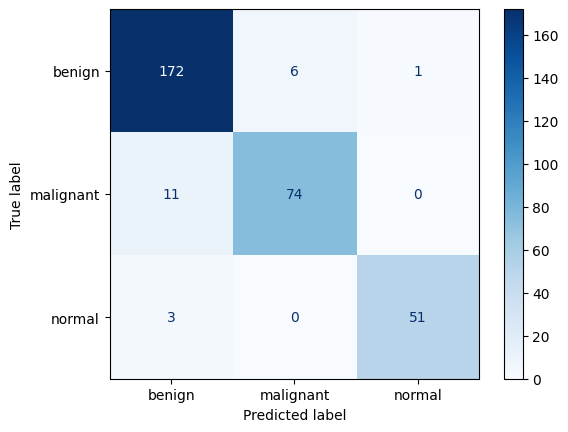

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load the classification model
classification_model = load_model('classification_model.keras')

# Data generator for the new dataset
val_datagen = ImageDataGenerator(rescale=1./255)

# Create a data generator for the new dataset
new_data_dir = '/kaggle/working/breast_ultrasound_split/val'  # Adjust to your dataset path
new_data_generator = val_datagen.flow_from_directory(
    new_data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False
)

# Make predictions on the new dataset
new_data_generator.reset()
predictions = classification_model.predict(new_data_generator)

# Get the predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class indices
true_classes = new_data_generator.classes
class_labels = list(new_data_generator.class_indices.keys())

# Display classification report
print("Classification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [134]:
import shutil

shutil.move('unet_final_enhanced_lr.keras', '/kaggle/working/unet_final_enhanced_lr.keras')
shutil.move('classification_model.keras', '/kaggle/working/classification_model.keras')


'/kaggle/working/classification_model.keras'

In [137]:
from flask import Flask, request, render_template
import tensorflow as tf
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os

app = Flask(__name__)

# Define the dice coefficient
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

# Register the dice coefficient with TensorFlow
tf.keras.utils.get_custom_objects().update({'dice_coefficient': dice_coefficient})

# Load the models
segmentation_model = load_model('unet_final_enhanced_lr.keras', custom_objects={'dice_coefficient': dice_coefficient})
classification_model = load_model('classification_model.keras')
